# Проект: Прогнозирование оттока клиентов для телеком компании

# 1. Задача проекта.

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала
персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Основная метрика: `ROC-AUC`.  
Дополнительная метрика: `Accuracy`.


## 1.1. Описание услуг.

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:
* Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*).
* Выделенная линия технической поддержки (*TechSupport*).
* Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*).
* Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


## 1.2. Описание данных.

Данные состоят из файлов, полученных из разных источников:
* `contract_new.csv` — информация о договоре;
* `personal_new.csv` — персональные данные клиента;
* `internet_new.csv` — информация об интернет-услугах;
* `phone_new.csv` — информация об услугах телефонии.  

Во всех файлах столбец `customerID` содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.


## 1.3. План работ.

1. Загрузка и исследование данных.
* Корректная загрузка всех четырёх датафреймов.
* Первичный анализ.
* Предварительные выводы.


2. Анализ и моделирование.
* Разведочный анализ (EDA).
* Feature Engineering (Синтетические признаки).
* Проверка мультиколлинеарности признаков и корреляции с таргетом.
* Feature selection (отбор признаков).
* Исследование моделей (не менее 2).
* Подбор гиперпараметров (на кросс-валидации с GridSearchCV).
* Выбор лучшей модели (по метрике на кроссвалидации model.best_score_).
* Определение итоговой метрики на тестовой выборке.
* Анализ важности признаков выбранной модели.

3. Итоговые выводы.

# 2. Загрузка и исследование данных.

In [1]:
#!pip install skimpy -q
#!pip install imblearn -q
#!pip install missingno -q

In [2]:
import warnings
warnings.filterwarnings('ignore')


import os
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import phik
import time
import re

from skimpy import skim, clean_columns
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb


import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import uniform, loguniform
from phik.report import plot_correlation_matrix
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     RandomizedSearchCV, 
                                     KFold, cross_val_score)
from sklearn.preprocessing import (OrdinalEncoder, StandardScaler,
                                   MinMaxScaler, OneHotEncoder)
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              StackingClassifier)
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from sklearn.dummy import DummyClassifier


# Введем глобальные переменные:
RANDOM_STATE_FIX = 12345
TEST_SIZE_FIX = 0.25

# Настроим вид таблиц:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
# Ограничим ширину отображающихся столбцов
pd.options.display.max_colwidth = 50
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
# Настроим, чтобы числа в датасетах отражались с 3 знаками после запятой
pd.set_option('display.float_format', '{:.2f}'.format) 

## 2.1 Чтение данных.

Так как файлов с данными несколько, то:
1) Заведем имена файлов с датафпеймами в список.
2) Будем читать файлы и на локальном компьютере, и на удаленном сервере согласно заведенного списка.
3) Создадим словарь и по ключу словаря будем обращаться к нужному датасету.

Кроме того:
* Отмечаем, что во всех файлах значения отделены запятыми.  
* Обращаем внимание на то, что во всех файлах первым признаком идёт `customerID`. Его и переведём в индексы. 

In [3]:
files = ['contract_new.csv', 
         'internet_new.csv',
         'personal_new.csv',
         'phone_new.csv'
        ]

local_path = 'datasets/'  
remote_path = 'https://code.s3.yandex.net/datasets/'

df = {}
for file in files:
    if os.path.exists(local_path + file):
        df[file[:-4]] = pd.read_csv(local_path+file, index_col=[0], sep=',')
        print('Local dataset "' + file + '" is loaded successfully.')
    elif os.path.exists(remote_path + file):
        df[file[:-4]] = pd.read_csv(remote_path+file, index_col=[0], sep=',')
        print('Remote dataset "' + file + '" is loaded successfully.')
    else:
        print('Something is wrong with "' + file + '" !!!')

Local dataset "contract_new.csv" is loaded successfully.
Local dataset "internet_new.csv" is loaded successfully.
Local dataset "personal_new.csv" is loaded successfully.
Local dataset "phone_new.csv" is loaded successfully.


In [4]:
# Проверим имена ключей в df:
[print(key) for key in df.keys()];

contract_new
internet_new
personal_new
phone_new


**Отмечаем**, что имена ключей в `df` корректные.

In [5]:
# Посмотрим размеры датафреймов.
[print(key, ' - ', value.shape) for key, value in df.items()];

contract_new  -  (7043, 7)
internet_new  -  (5517, 7)
personal_new  -  (7043, 4)
phone_new  -  (6361, 1)


`contract_new.csv` — договор;  
`internet_new.csv` — интернет;  
`personal_new.csv` — клиент;  
`phone_new.csv` — телефония.

**Промежуточные выводы:**
* данные успешно загрузились;
* объёмы в разных датафреймах отличаются;
* датафреймы с информацией о договоре и клиентах имеют одинаковое количество объектов.

## 2.2. Проверка названия столбцов и приведение их все к стилю `snake_case`.

In [6]:
# Посмотрим названия столбцов.
[print(key, ': ', value.columns) for key, value in df.items()];

contract_new :  Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')
internet_new :  Index(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')
personal_new :  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')
phone_new :  Index(['MultipleLines'], dtype='object')


**Отмечаем:**
* названия столбцов следует привести к стилю `snake_case`.

In [7]:
# Затем приведём к стилю `snake_case`.

for key, value in df.items():
    columns_name = clean_columns(df[key]).columns.tolist();
    df[key].columns = columns_name
    
# Посмотрим новые названия столбцов.

print('=' * 80)
print('Обновлённые названия столбцов:\n')
[print(key, ': ', value.columns) for key, value in df.items()];

7 column names have been cleaned

7 column names have been cleaned

3 column names have been cleaned

1 column names have been cleaned

Обновлённые названия столбцов:

contract_new :  Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges'],
      dtype='object')
internet_new :  Index(['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
personal_new :  Index(['gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
phone_new :  Index(['multiple_lines'], dtype='object')


**Промежуточные выводы:**

* Названия всех столбцов во всех датафреймах приведены к стилю *snake_case*.
* В дальнейшем к ним можно обращаться через точку.

Создадим вспомогательную функцию для единообразного изучения датафрейма.

In [8]:
def view_df(df_temp):
    '''
    Функция для единообразного изучения датафреймов.
    '''
    skim(df_temp)
    display(df_temp.head(3))
    display(df_temp.tail(3))
    print('Количество явных дубликатов:', df_temp.duplicated().sum())
    print('Количество пропущенных значений по всем признакам:', 
          df_temp.isnull().sum().sum())

## 2.3. Изучение данных, содержащиеся в датафреймах.

###  2.3.1. `contract_new.csv` — данные о договорах.  

In [9]:
# Изучим содержимое датафрейма:

view_df(df['contract_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7043   │ │ string      │ 6     │                                                          │
│ │ Number of columns │ 7      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA    ┃ NA %    ┃ mean    ┃ sd   ┃ p0   ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ monthly_charges          │     0 │       0 │      65 │   30 │   18 │     36 │     90 │     120 │  █▃▄▇▇▃   │  │
│ └──────────────────────────┴───────┴─────────┴─────────┴──────┴──────┴────────┴────────┴─────────┴───────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                       ┃ NA     ┃ NA %      ┃ words per row             ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ begin_date                        │      0 │         0 │                         1 │                  7000 │  │
│ │ end_date                          │      0 │         0 │                         1 │                  7000 │  │
│ │ type                              │      0 │         0 │                         1 │                  7000 │  │
│ │ paperless_billing                 │      0 │         0 │                         1 │                  7000 │  │
│ │ payment_method                    │      0 │         0 │                         1 │                  7000 │  │
│ │ total_charges                     │      0 │         0 │                         1 │                  7000 │  │
│ └───────────────────────────────────┴────────┴───────────┴───────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8
3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82


Количество явных дубликатов: 37
Количество пропущенных значений по всем признакам: 0


Видим, что есть дубликаты. Проверим индексы.

In [10]:
len(df['contract_new'].index.unique())

7043

Все значения индекса `customerID` уникальны. Таким образом, неявных дубликатов тоже нет.

**Посмотрим период времени, в течении которого заключались и закрывались контракты.**

In [11]:
display(df['contract_new'].min())
print('-' * 50)
display(df['contract_new'].max())

begin_date                          2013-10-01
end_date                            2014-06-01
type                            Month-to-month
paperless_billing                           No
payment_method       Bank transfer (automatic)
monthly_charges                          18.25
total_charges                                 
dtype: object

--------------------------------------------------


begin_date             2020-02-01
end_date                       No
type                     Two year
paperless_billing             Yes
payment_method       Mailed check
monthly_charges            118.75
total_charges               999.9
dtype: object

In [12]:
df['contract_new'].end_date.value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: end_date, Length: 67, dtype: int64

**Отмечаем**, что в нашей выборке есть данные по контрактам телеком компании с клиентами, которые:
1. заключались в период с 2013-10-01 по 2020-02-01,
2. закрывались в период с 2014-11-01 по 2020-01-01,
3. не были закрыты на момент выборки данных, т.е. в феврале 2020.

**Содержимое признаков.**

Создадим дополнительную функцию.

In [13]:
def feature_unique(df_name, feature_name):
    '''
    Печать информации по количеству уникальных значений
    признака и списка его уникальных значений.
    '''
    print('\nКоличество уникальных значений признака "',
          feature_name, '" в датасете "', 
          df_name, '" равно',
          len(df[df_name][feature_name].unique()))
    
    print('Список возможных значений:',
          df[df_name][feature_name].unique())
#    print(df[df_name][feature_name].value_counts(dropna=False))

In [14]:
# Список признаков:
list_feature_contract = ['type', 'paperless_billing', 'payment_method', 
                         'total_charges', 'monthly_charges']

# Печать информации по уникальным значениям признаков:
for name in list_feature_contract:
    feature_unique('contract_new', name)


Количество уникальных значений признака " type " в датасете " contract_new " равно 3
Список возможных значений: ['Month-to-month' 'One year' 'Two year']

Количество уникальных значений признака " paperless_billing " в датасете " contract_new " равно 2
Список возможных значений: ['Yes' 'No']

Количество уникальных значений признака " payment_method " в датасете " contract_new " равно 4
Список возможных значений: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Количество уникальных значений признака " total_charges " в датасете " contract_new " равно 6658
Список возможных значений: ['31.04' '2071.84' '226.17' ... '325.6' '520.8' '7251.82']

Количество уникальных значений признака " monthly_charges " в датасете " contract_new " равно 1585
Список возможных значений: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]


**Отмечаем**:
1. признак "`type`" - яаляется категориальным с 3 значениями: 
    * "Month-to-month", 
    * "One year", 
    * "Two year";
2. признак "`paperless_billing`" является бинарным со значениями 'Yes' или 'No';
3. признак "`payment_method`" - категориальным с 4 значениями: 
    * "Electronic check", 
    * "Mailed check", 
    * "Bank transfer (automatic)", 
    * "Credit card (automatic)";
4. признак "`total_charges`" - является числовым, имеет тип 'string', котопый нужно заменить на 'float';
5. признак "`monthly_charges`" - является числовым и имеет тип 'float'.

In [15]:
# Для признака "total_charges" заменим тип со строкового на числовой:
df['contract_new'].total_charges = \
    pd.to_numeric(df['contract_new'].total_charges, errors='coerce')

In [16]:
df['contract_new'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7032 non-null   float64
dtypes: float64(2), object(5)
memory usage: 698.2+ KB


**Посмотрим распределение потраченных на услуги денег.**

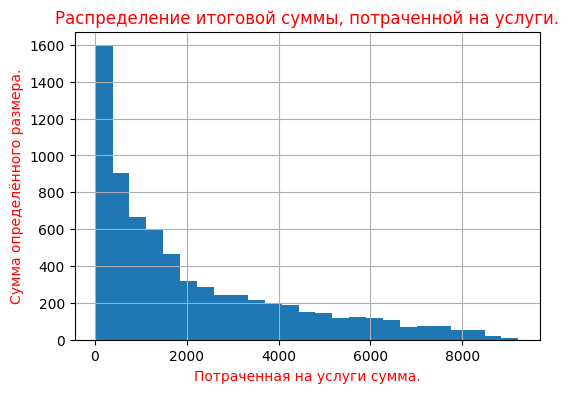

In [17]:
plt.figure(figsize=(6, 4))
plt.grid(True)
plt.xlabel('Потраченная на услуги сумма.', fontsize=10, color='red')
plt.ylabel('Сумма определённого размера.', 
           fontsize=10, color='red')
plt.title(f'Распределение итоговой суммы, потраченной на услуги.',
          fontsize=12, color='red')
plt.hist(df['contract_new'].total_charges, bins=25);

**Отмечаем**:
* пик значений затраченных сумм находится до 500,
* далее наблюдается резкое уменьшение с плавным окончанием в районе 10000. 

**Посмотрим распределение ежемесячных затрат на услуги.**

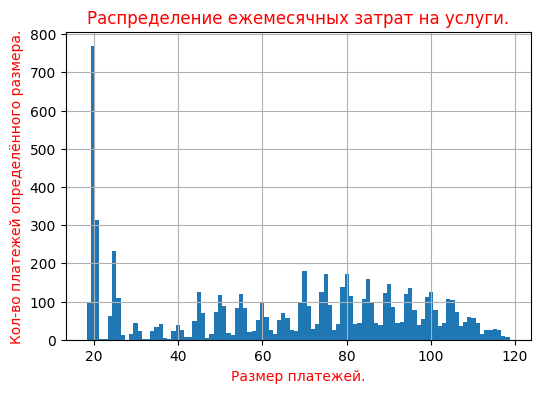

In [18]:
plt.figure(figsize=(6, 4))
plt.grid(True)
plt.xlabel('Размер платежей.', fontsize=10, color='red')
plt.ylabel('Кол-во платежей определённого размера.', 
           fontsize=10, color='red')
plt.title(f'Распределение ежемесячных затрат на услуги.',
          fontsize=12, color='red')
plt.hist(df['contract_new'].monthly_charges, bins=100);

**Отмечаем**:
* пик значений платежа около 20,
* распределение имеет пики при значениях, кратных 5. Видимо, такие тарифы у компании, целые с круглыми цифрами.

**Промежуточные выводы:**
1. В `'contract_new'` содержится информация о заключенных контрактах со следующими признаками:
    * `begin_date` - дата начала пользования услугами,
    * `end_date` - дата окончания пользования услугами,
    * `type` - тип оплаты: ежемесячный, годовой и тд,
    * `paperless_billing` - безналичный расчёт,
    * `payment_method` - способ оплаты,
    * `total_charges` - всего потрачено денег на услуги,
    * `monthly_charges` - ежемесячные траты на услуги.
2. Датафрейм состоит из 7043 строк и 7 столбцов.
3. Признак `monthly_charges` имеет тип float, остальные - object.
4. Пропусков нет.
5. Дубликатов нет.
6. Предоставленные данные охватывают периоды:
    * заключения контактов: от `2013-10-01` по `2020-02-01`.
    * закрытия контактов: от `2014-06-01` по `настоящее время` действующие.
7. Признаки, имеющее малое количество значений:
    * 3 признака `type` - тип оплаты:
        * *'Month-to-month'*, 
        * *'One year'*, 
        * *'Two year*'.
    * 2 признака `paperless_billing` - тип оплаты: 
        * *'Yes'*, 
        * *'No'*.
    * 4 признака `payment_method` - тип оплаты: 
        * *'Electronic check'*, 
        * *'Mailed check'*, 
        * *'Bank transfer (automatic)'*, 
        * *'Credit card (automatic)'*.
8. Для признака "total_charges" тип данных изменён со строкового на числовой.
    * пик значений затраченных сумм находится до 500,
    * далее наблюдается резкое уменьшение с плавным окончанием в районе 10000. 
9. Распределение ежемесячных затрат на услуги имеет:
    * пик значений платежа около 20,
    * распределение имеет пики при значениях, кратных 5. 

### 2.3.2. `internet_new.csv` — данные об интернет-услугах.  

In [19]:
# Изучим содержимое датафрейма:
view_df(df['internet_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5517   │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 7      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                       ┃ NA     ┃ NA %      ┃ words per row             ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ internet_service                  │      0 │         0 │                       1.6 │                  8600 │  │
│ │ online_security                   │      0 │         0 │                       1.6 │                  8600 │  │
│ │ online_backup                     │      0 │         0 │                       1.6 │                  8600 │  │
│ │ device_protection                 │      0 │         0 │                       1.6 │                  8600 │  │
│ │ tech_support                      │      0 │         0 │                       1.6 │                  8600 │  │
│ │ streaming_tv                      │      0 │         0 │                       1.6 │                  8600 │  │
│ │ streaming_movies                  │      0 │         0 │                       1.6 │                  8600 │  │
│ └───────────────────────────────────┴────────┴───────────┴───────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No


,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customerID,,,,,,,
4801-JZAZL,DSL,Yes,No,No,No,No,No
8361-LTMKD,Fiber optic,No,No,No,No,No,No
3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


Количество явных дубликатов: 5389
Количество пропущенных значений по всем признакам: 0


Видим, что есть дубликаты. Проверим индексы.

In [20]:
len(df['internet_new'].index.unique())

5517

Все значения индекса `customerID` уникальны. Таким образом, неявных дубликатов тоже нет.

In [21]:
# Список признаков:
list_feature_internet = ['internet_service', 'online_security', 
    'online_backup', 'device_protection', 'tech_support', 
    'streaming_tv', 'streaming_movies']

# Печать информации по уникальным значениям признаков:
for name in list_feature_internet:
    feature_unique('internet_new', name)


Количество уникальных значений признака " internet_service " в датасете " internet_new " равно 2
Список возможных значений: ['DSL' 'Fiber optic']

Количество уникальных значений признака " online_security " в датасете " internet_new " равно 2
Список возможных значений: ['No' 'Yes']

Количество уникальных значений признака " online_backup " в датасете " internet_new " равно 2
Список возможных значений: ['Yes' 'No']

Количество уникальных значений признака " device_protection " в датасете " internet_new " равно 2
Список возможных значений: ['No' 'Yes']

Количество уникальных значений признака " tech_support " в датасете " internet_new " равно 2
Список возможных значений: ['No' 'Yes']

Количество уникальных значений признака " streaming_tv " в датасете " internet_new " равно 2
Список возможных значений: ['No' 'Yes']

Количество уникальных значений признака " streaming_movies " в датасете " internet_new " равно 2
Список возможных значений: ['No' 'Yes']


**Промежуточные выводы:**
1. В `'internet_new'` содержится информация о предоставляемых интернет услугах
2. Датафрейм состоит из 5517 строк и 7 столбцов.
3. Все признаки имеют тип *object*.
4. Пропусков нет.
5. Содержимое признаков:
    * `internet_service` - подключение к интернет,
    * `online_security` - блокировка небезопасных сайтов,
    * `online_backup` - предоставление облачного хранилища файлов для резервного копирования данных,
    * `device_protection` - антивирус,
    * `tech_support` - выделенние линии технической поддержки,
    * `streaming_tv` - стриминговое телевидение,
    * `streaming_movies` - каталог фильмов.
6. Все признаки категориальные, имеют всего по два значения:
    * признак `internet_service` -  
        * *'DSL'* - телефонная линия (DSL, от англ. digital subscriber line, «цифровая абонентская линия»), 
        * *'Fiber optic'* - оптоволоконный кабель.
    * остальные признаки -  
        * *'Yes'*, 
        * *'No'*.

### 2.3.3. `personal_new.csv` — персональные данные клиента .

In [22]:
# Изучим содержимое датафрейма:
view_df(df['personal_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7043   │ │ string      │ 3     │                                                          │
│ │ Number of columns │ 4      │ │ int32       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0   ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ senior_citizen         │    0 │       0 │    0.16 │    0.37 │    0 │      0 │      0 │       1 │  █    ▂   │  │
│ └────────────────────────┴──────┴─────────┴─────────┴─────────┴──────┴────────┴────────┴─────────┴───────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ gender                    │       0 │          0 │                            1 │                     7000 │  │
│ │ partner                   │       0 │          0 │                            1 │                     7000 │  │
│ │ dependents                │       0 │          0 │                            1 │                     7000 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,gender,senior_citizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No


,gender,senior_citizen,partner,dependents
customerID,,,,
4801-JZAZL,Female,0,Yes,Yes
8361-LTMKD,Male,1,Yes,No
3186-AJIEK,Male,0,No,No


Количество явных дубликатов: 7027
Количество пропущенных значений по всем признакам: 0


Видим, что есть дубликаты. Проверим индексы.

In [23]:
len(df['personal_new'].index.unique())

7043

Все значения индекса `customerID` уникальны. Таким образом, неявных дубликатов тоже нет.

In [24]:
# Список признаков:
list_feature_personal = ['gender', 'senior_citizen', 
    'partner', 'dependents']

# Печать информации по уникальным значениям признаков:
for name in list_feature_personal:
    feature_unique('personal_new', name)


Количество уникальных значений признака " gender " в датасете " personal_new " равно 2
Список возможных значений: ['Female' 'Male']

Количество уникальных значений признака " senior_citizen " в датасете " personal_new " равно 2
Список возможных значений: [0 1]

Количество уникальных значений признака " partner " в датасете " personal_new " равно 2
Список возможных значений: ['Yes' 'No']

Количество уникальных значений признака " dependents " в датасете " personal_new " равно 2
Список возможных значений: ['No' 'Yes']


**Промежуточные выводы:**
1. В `'personal_new'` содержатся персональные данные клиентов телесоммуникционной компании.
3. Признак `senior_citizen` имеет тип 'int', остальные признаки имеют тип 'object'.
4. Пропусков нет.
5. Содержимое признаков:
    * `gender` - пол,
    * `senior_citizen` - наличие пенсионного статуса по возрасту,
    * `partner` - наличие супруга(и),
    * `dependents` - наличие иждивенцев.
5. Все признаки бинарные, имеют всего по два значения:
    * признак `gender`:
        * *'Female'*, 
        * *'Male'*.
    * признак `senior_citizen`:
        * *'0'*, 
        * *'1'*.
    * признаки `partner` и `dependents`:  
        * *'Yes'*, 
        * *'No'*.

### 2.3.4. `phone_new.csv` — информация об услугах телефонии.

In [25]:
# Изучим содержимое датафрейма:
view_df(df['phone_new'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 6361   │ │ string      │ 1     │                                                          │
│ │ Number of columns │ 1      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                   ┃ NA     ┃ NA %       ┃ words per row               ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ multiple_lines                │      0 │          0 │                           1 │                   6400 │  │
│ └───────────────────────────────┴────────┴────────────┴─────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,multiple_lines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No


,multiple_lines
customerID,
2234-XADUH,Yes
8361-LTMKD,Yes
3186-AJIEK,No


Количество явных дубликатов: 6359
Количество пропущенных значений по всем признакам: 0


Видим, что есть дубликаты. Проверим индексы.

In [26]:
len(df['phone_new'].index.unique())

6361

Все значения индекса `customerID` уникальны. Таким образом, неявных дубликатов тоже нет.

In [27]:
# Печать информации по уникальным значениям признаков:
feature_unique('phone_new', 'multiple_lines')


Количество уникальных значений признака " multiple_lines " в датасете " phone_new " равно 2
Список возможных значений: ['No' 'Yes']


**Промежуточные выводы:**
1. В `'phone_new'` содержится информация об услугах телефонии:
    * `multiple_lines` - наличие возможности ведения параллельных линий во время звонка.
2. Датафрейм состоит из 6361 строк и 1 столбца.
3. Признак `multiple_lines` имеет тип object.
4. Пропусков нет.
5. Признак имеет всего два значения:
   * *'Yes'*, 
   * *'No'*.

# 3. Разведочный анализ (EDA).

### 3.1. Объединение датасетов.

In [28]:
data = df['contract_new'] \
    .merge(df['internet_new'], how='outer', on='customerID')\
    .merge(df['personal_new'], how='outer', on='customerID')\
    .merge(df['phone_new'], how='outer', on='customerID')\
    .reset_index(drop=True)

# Изучим содержимое датафрейма:
view_df(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7043   │ │ string      │ 16    │                                                          │
│ │ Number of columns │ 19     │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name             ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0   ┃ p25   ┃ p75     ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ monthly_charges         │    0 │       0 │      65 │      30 │   18 │    36 │      90 │     120 │  █▃▄▇▇▃  │  │
│ │ total_charges           │   11 │    0.16 │    2100 │    2100 │   19 │   440 │    3200 │    9200 │  █▃▂▁▁   │  │
│ │ senior_citizen          │    0 │       0 │    0.16 │    0.37 │    0 │     0 │       0 │       1 │  █    ▂  │  │
│ └─────────────────────────┴──────┴─────────┴─────────┴─────────┴──────┴───────┴─────────┴─────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA        ┃ NA %      ┃ words per row            ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ begin_date                       │         0 │         0 │                        1 │                 7000 │  │
│ │ end_date                         │         0 │         0 │                        1 │                 7000 │  │
│ │ type                             │         0 │         0 │                        1 │                 7000 │  │
│ │ paperless_billing                │         0 │         0 │                        1 │                 7000 │  │
│ │ payment_method                   │         0 │         0 │                        1 │                 7000 │  │
│ │ internet_service                 │      1500 │        22 │                        1 │                 7000 │  │
│ │ online_security                  │      1500 │        22 │                        1 │                 7000 │  │
│ │ online_backup                    │      1500 │        22 │                        1 │                 7000 │  │
│ │ device_protection                │      1500 │        22 │                        1 │                 7000 │  │
│ │ tech_support                     │      1500 │        22 │                        1 │                 7000 │  │
│ │ streaming_tv                     │      1500 │        22 │                        1 │                 7000 │  │
│ │ streaming_movies                 │      1500 │        22 │                        1 │                 7000 │  │
│ │ gender                           │         0 │         0 │                        1 │                 7000 │  │
│ │ partner                          │         0 │      

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
7040,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.60,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,NaN
7041,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.80,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes
7042,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Male,0,No,No,No


Количество явных дубликатов: 4
Количество пропущенных значений по всем признакам: 11375


Видим, что есть дубликаты. Проверим индексы.

In [29]:
len(data.index.unique())

7043

Все значения индекса `customerID` уникальны. Таким образом, неявных дубликатов тоже нет.

### 3.2. Преобразование значений даты и времени.

In [30]:
# Диапазон значений даты закрытия контракта:
data.end_date.value_counts().head()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
Name: end_date, dtype: int64

Отмечаем:
* последняя дата - '2020-01-01',
* даты меняются по месяцам.

Чтобы отличать продолжающиеся контракты от закрытых в последний наблюдаемый месяц, **присвоим незакрытым контрактам дату '2020-02-01'**.

In [31]:
data.loc[data.end_date == 'No', 'end_date'] = '2020-02-01'
data.end_date.value_counts().head()

2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
Name: end_date, dtype: int64

In [32]:
# Заменим тип данных значений даты на `datatime`:
data['begin_date'] = pd.to_datetime(data.begin_date, format='%Y-%m-%d')
data['end_date'] = pd.to_datetime(data.end_date, format='%Y-%m-%d')
print("Признак 'begin_date' имеет тип ", data.begin_date.dtypes)
print("Признак 'end_date' имеет тип ", data.end_date.dtypes)

Признак 'begin_date' имеет тип  datetime64[ns]
Признак 'end_date' имеет тип  datetime64[ns]


### 3.3. Заполнение пропущенных значений.

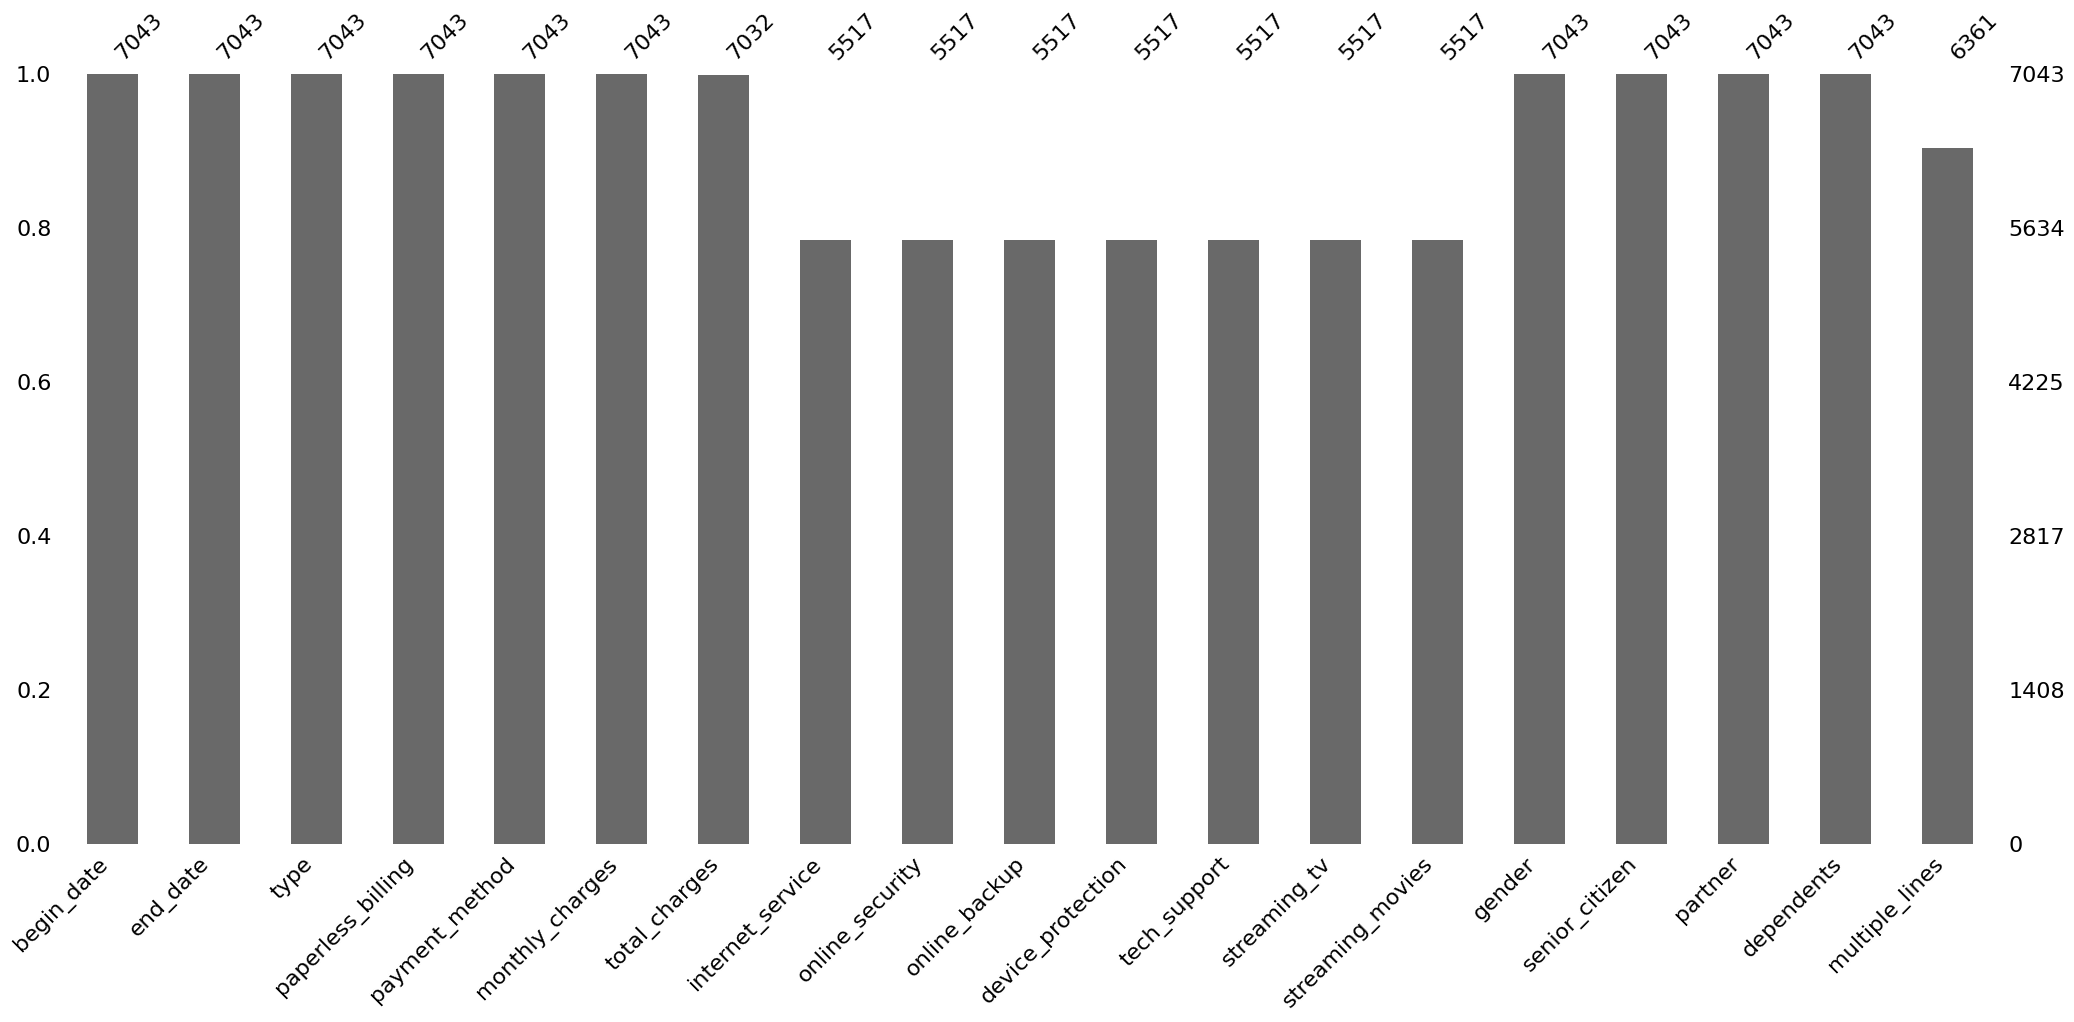

In [33]:
# Посмотрим признаки с пропущенными значениями:
msno.bar(data);

**Отмечаем**:
* ~ 10 пропусков в признаке 'total_charges'.
* ~ 1500 пропусков в признаках из датафрейма `internet_new`. 
* ~ 680 пропусков в признаке `multiple_lines` из датафрейма `phone_new`.

### 3.3.1. Пропущенные значения в признаке 'total_charges'. 

Таких пропусков немного, всего 11. Посмотрим их внимательнее.

In [34]:
data[data['total_charges'].isnull()]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
488,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
753,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,Yes,No
936,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
1340,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
3331,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
3826,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,Yes
4380,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,Yes,Yes,No
5218,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
6670,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


**Отмечаем**:
* Все 11 записей с пропущенными значениями 'total_charges' (полной суммы денег за оказанные услуги) имеют длительность контракта всего 1 месяц.
* Поэтому, модем присвоить 'total_charges' значение помесячной оплаты.

In [35]:
# Заменим пропуски 'total_charges' значением помесячной оплаты.
data.total_charges = data.total_charges.fillna(data.monthly_charges)

# Проверим количество пропусков:
data.total_charges.isnull().sum()

0

**Отмечаем** , что в признаке 'total_charges' нет пропущенных значений.

### 3.3.2. Пропущенные значения  в признаке `multiple_lines` из датафрейма `phone_new`.

`multiple_lines` - наличие возможности ведения параллельных линий во время звонка.

In [36]:
# Проверим количество пропусков:
print(data.multiple_lines.unique())
data.multiple_lines.isnull().sum()

[nan 'No' 'Yes']


682

Видимо, клиенты не пользуются услугами телефонии. А потому заполним пропуски значением 'No'.

In [37]:
data.multiple_lines.fillna('No',inplace = True)
# Проверим количество пропусков:
data.multiple_lines.isnull().sum()

0

**Отмечаем** , что в признаке 'multiple_lines' нет пропущенных значений.

### 3.3.3. Пропущенные значения в признаках из датафрейма `internet_new`. 

In [38]:
print('Признаки с пропущенными значениями:')
#display(data.loc[:, data.columns[data.isna().any()]].isna().sum())
for feature in list_feature_internet:
    print(feature, '   \t',
        data[feature].isna().sum(), '\t',
        data[feature].unique())

Признаки с пропущенными значениями:
internet_service    	 1526 	 ['DSL' 'Fiber optic' nan]
online_security    	 1526 	 ['No' 'Yes' nan]
online_backup    	 1526 	 ['Yes' 'No' nan]
device_protection    	 1526 	 ['No' 'Yes' nan]
tech_support    	 1526 	 ['No' 'Yes' nan]
streaming_tv    	 1526 	 ['No' 'Yes' nan]
streaming_movies    	 1526 	 ['No' 'Yes' nan]


Содержимое признаков:
* `internet_service` - подключение к интернет,
* `online_security` - блокировка небезопасных сайтов,
* `online_backup` - предоставление облачного хранилища файлов для резервного копирования данных,
* `device_protection` - антивирус,
* `tech_support` - выделенние линии технической поддержки,
* `streaming_tv` - стриминговое телевидение,
* `streaming_movies` - каталог фильмов.  

Видимо, клиенты не пользуются предоставленными услугами интернет. А потому заполним пропуски значением 'No'.

In [39]:
data = data.fillna('No')

# Проверим количество пропусков:
data.isnull().sum().sum()

0

**Промежуточные выводы**: пропущенных значений больше нет.

### 3.4. Feature Engineering (Синтетические признаки).

In [40]:
data.head(2)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No
1,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No


### 3.4.1 Создание целевого признака.

Нужен признак, содержащий информацию о том, ушёл клиент или продолжает сотрудничество.
Это можно получить из информации о дате расторжении контракта. Если нет даты расторжения контракта (в этом случае мы присвоили значение '2020-02-01'), значит клиент продолжает сотрудничать.

Посмотрим содержимое признака `end_date`:

In [41]:
data.end_date.value_counts().head()

2020-02-01    5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
Name: end_date, dtype: int64

In [42]:
# Создадим целевой признак 'keep_client' c информацией:
# 1 - человек остается клиентом банка,
# 0 - человек ушёл из банка.
data['keep_client'] = np.where(data.end_date == '2020-02-01', 1, 0)
data.keep_client.sample(5)

4580    1
1096    1
5487    1
883     1
4012    1
Name: keep_client, dtype: int32

Создан целевой признак `keep_client`.

### 3.4.2. Создание признака `длительность договорных отношений`.

У нас есть информация о времени заключения договора, о времени его закрытия или о том, что договор продолжает действовать или нет.

Для решения нашей задачи важно не само значение времени, а продолжительность договорных отношений.

In [43]:
# Создание признака `длительность договорных отношений`:
data['duration'] =(data.end_date - data.begin_date) / np.timedelta64 ( 1 , 'D')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   internet_service   7043 non-null   object        
 8   online_security    7043 non-null   object        
 9   online_backup      7043 non-null   object        
 10  device_protection  7043 non-null   object        
 11  tech_support       7043 non-null   object        
 12  streaming_tv       7043 non-null   object        
 13  streaming_movies   7043 non-null   object        
 14  gender  

In [44]:
# Примеры значений длительности:
data.duration.sample(5)

1078   1798.00
6296    945.00
4538    123.00
1417    549.00
5357   1826.00
Name: duration, dtype: float64

### 3.5. Закономерности поведения клиентов.

### 3.5.1. Распределение количества заключенных/расторгнутых контрактов по времени. 

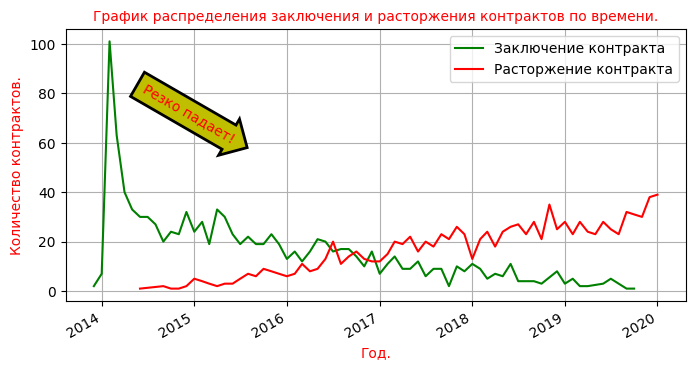

In [45]:
plt.figure(figsize=(8, 4))

data.loc[data['keep_client'] == 0,'begin_date'].value_counts().plot(
    grid=True, color='green')
data.loc[data['keep_client'] == 0,'end_date'].value_counts().plot(
    grid=True, color='red')

plt.title("График распределения заключения и расторжения контрактов по времени.", 
          fontsize=10, color='red')
plt.xlabel('Год.', fontsize=10, color='red')
plt.ylabel('Количество контрактов.', fontsize=10, color='red')
plt.legend(['Заключение контракта', 'Расторжение контракта'])
bbox_properties = dict(boxstyle='rarrow, pad=0.5', 
                       ec='k', fc='y', ls='-', lw=2)
plt.text("2014-06-01", 60, 'Резко падает!', color='red', 
         bbox=bbox_properties, rotation=-30)
plt.show()

**Отмечаем**
1. После скачкообразного количества заключенных контрактов на рубеже 2014 года (видимо, после создания телекоммуникационной компании) очень быстро их количество уменьшилось.
2. Количество заключаемых новых контрактов постоянно уменьшается, практически до нуля к конце 2020 года. 
3. Примерно через полгода после образования компании, люди стали уходить от сотрудничества с ней. И этот процесс только увеличивался.

### 3.5.2. Распределение полной суммы оплаты по типам оплаты и гендеру.

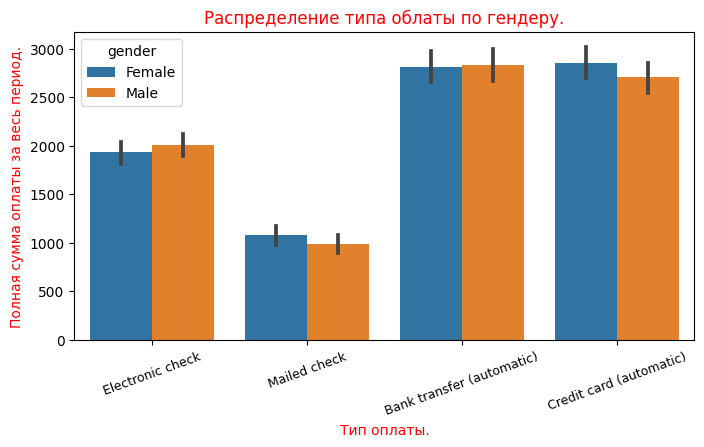

In [46]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x="payment_method", y="total_charges", hue="gender",  data=data)
ax.set_xticklabels(data.payment_method.unique(), rotation=20, fontsize=9)
plt.xlabel('Тип оплаты.', fontsize=10, color='red')
plt.ylabel('Полная сумма оплаты за весь период.', fontsize=10, color='red')
plt.title("Распределение типа облаты по гендеру.", 
          fontsize=12, color='red')
plt.show()

**Отмечено**:
* гендерного различия не оюнаружено;
* распределение числа клиентов по способу оплаты не содержит аномальных значений. Тем не менее, наблюдаем, что большая часть клиентов предпочитают электронную оплату.

### 3.5.3. Распределение в категориальных признаках с информацией о контрактах.

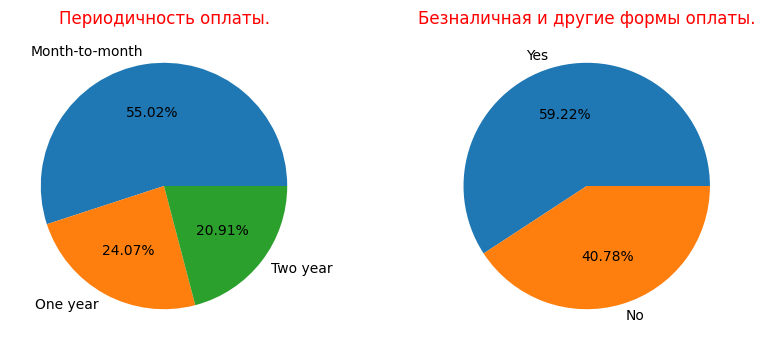

In [47]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
ax1.pie(data.type.value_counts().values, 
        labels = data.type.unique(),
        autopct='%1.2f%%')
ax1.set_title('Периодичность оплаты.', color='red')

ax2 = fig.add_subplot(122)
ax2.pie(data.paperless_billing.value_counts().values, 
        labels = data.paperless_billing.unique(),
        autopct='%1.2f%%')
ax2.set_title('Безналичная и другие формы оплаты.', color='red')

plt.show()


**Отмечаем**:
* большинство клиентов предпочитают ежемесячную форму оплаты;
* годовую и двухгодовую формы оплаты имеют примерно одинаковое количество клиентов;
* безналмчная форма оплаты встречается раза в полтора чаще, чем другие формы оплаты;
* аномальных значений и несбалансированности в признаках не отмечено.

### 3.5.4. Распределение в категориальных признаках с информацией об интернет-услугах.

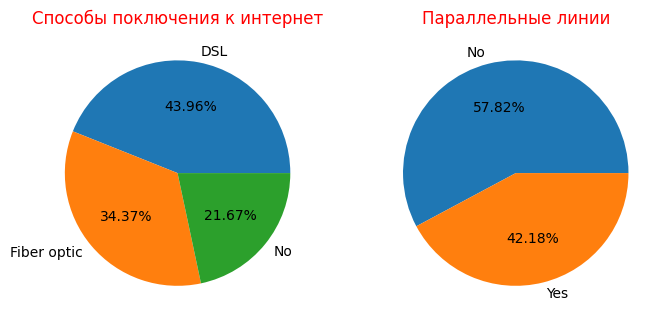

In [48]:
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax1.pie(data.internet_service.value_counts().values, 
        labels = data.internet_service.unique(),
        autopct='%1.2f%%')
ax1.set_title('Способы поключения к интернет', color='red')

ax2 = fig.add_subplot(122)
ax2.pie(data.multiple_lines.value_counts().values, 
        labels = data.multiple_lines.unique(),
        autopct='%1.2f%%')
ax2.set_title('Параллельные линии', color='red')

plt.show()

**Отмечаем**:
* для 22% клиентов нет информации о способе подключения к интернет;
* большая часть клиентов предпочитает DSL'(телефонная линия), чем Fiber optic'(оптоволоконный кабель).
* почти 60% клиентов не используют многоканальную телефонию;
* аномальных значений и несбалансированности в признаках не отмечено.

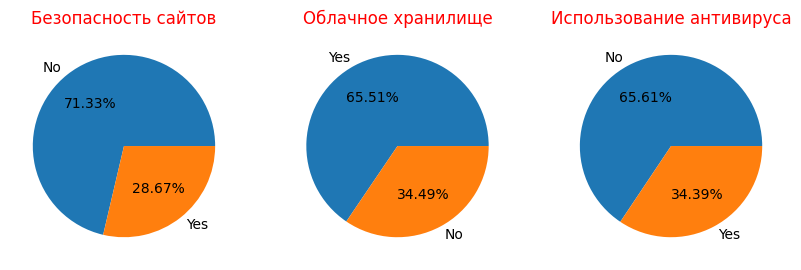

In [49]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(131)
ax1.pie(data.online_security.value_counts().values, 
        labels = data.online_security.unique(),
        autopct='%1.2f%%')
ax1.set_title('Безопасность сайтов', color='red')

ax2 = fig.add_subplot(132)
ax2.pie(data.online_backup.value_counts().values, 
        labels = data.online_backup.unique(),
        autopct='%1.2f%%')
ax2.set_title('Облачное хранилище', color='red')

ax3 = fig.add_subplot(133)
ax3.pie(data.device_protection.value_counts().values, 
        labels = data.device_protection.unique(),
        autopct='%1.2f%%')
ax3.set_title('Использование антивируса', color='red')

plt.show()

**Отмечаем**:
* почти в раза больше киентов, которые не пользуются услугами по блокировке небезопасных сайтов;
* 2/3 клиентов используют облачное хранилище;
* 2/3 клиентов не используют антивирус;
* наблюдается несбалансированность в признаках.

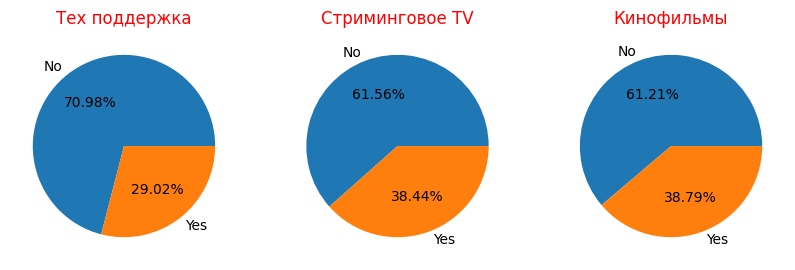

In [50]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(131)
ax1.pie(data.tech_support.value_counts().values, 
        labels = data.tech_support.unique(),
        autopct='%1.2f%%')
ax1.set_title('Тех поддержка', color='red')

ax2 = fig.add_subplot(132)
ax2.pie(data.streaming_tv.value_counts().values, 
        labels = data.streaming_tv.unique(),
        autopct='%1.2f%%')
ax2.set_title('Cтриминговое TV', color='red')

ax3 = fig.add_subplot(133)
ax3.pie(data.streaming_movies.value_counts().values, 
        labels = data.streaming_movies.unique(),
        autopct='%1.2f%%')
ax3.set_title('Кинофильмы', color='red')

plt.show()

**Отмечаем**:
* услугами технической поддержки пользуются менее 30% клиентов;
* услугой 'стриминговое телевидение' пользуются менее 40% клиентов;
* кинофильмы смотрят менее 40% клиентов;
* наблюдается несбалансированность в признаках.

### 3.5.5. Распределение в категориальных признаках с информацией персональных данных клиента.

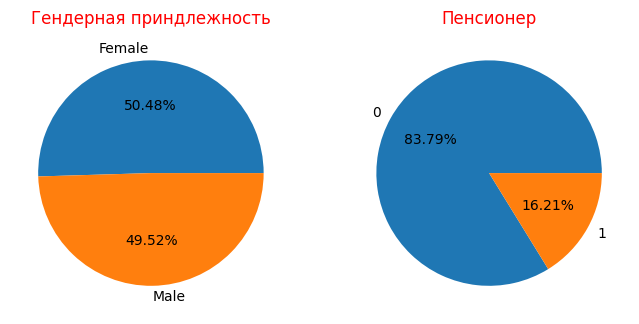

In [51]:
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax1.pie(data.gender.value_counts().values, 
        labels = data.gender.unique(),
        autopct='%1.2f%%')
ax1.set_title('Гендерная приндлежность', color='red')

ax2 = fig.add_subplot(122)
ax2.pie(data.senior_citizen.value_counts().values, 
        labels = data.senior_citizen.unique(),
        autopct='%1.2f%%')
ax2.set_title('Пенсионер', color='red')

plt.show()

**Отмечаем**:
* гендерное равенство среди клиентов компании;
* Пенсионеры составляют не более 1/6 от общего количества клиентов - дисбаланс.

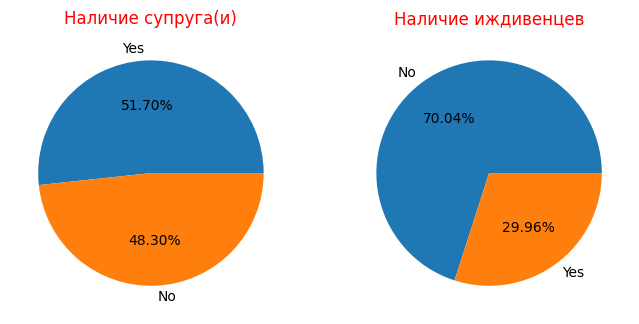

In [52]:
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)
ax1.pie(data.partner.value_counts().values, 
        labels = data.partner.unique(),
        autopct='%1.2f%%')
ax1.set_title('Наличие супруга(и)', color='red')

ax2 = fig.add_subplot(122)
ax2.pie(data.dependents.value_counts().values, 
        labels = data.dependents.unique(),
        autopct='%1.2f%%')
ax2.set_title('Наличие иждивенцев', color='red')

plt.show()

**Отмечаем**:
* семейные клиенты составляют половину об общего числа;
* иждивенцы есть только у 30% клиентов  - дисбаланс.

**Промежуточный вывод:**
* аномальных значений не отмечено;
* наблюдается несбалансированность в некоторых признаках.

## 3.6. Проверка мультиколлинеарности признаков.

Создадим дополнительную функцию для постройки тепловой карты с коэффициентами корреляции Пирсона.

  0%|          | 0/1 [00:00<?, ?it/s]

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'keep_client', 'duration']


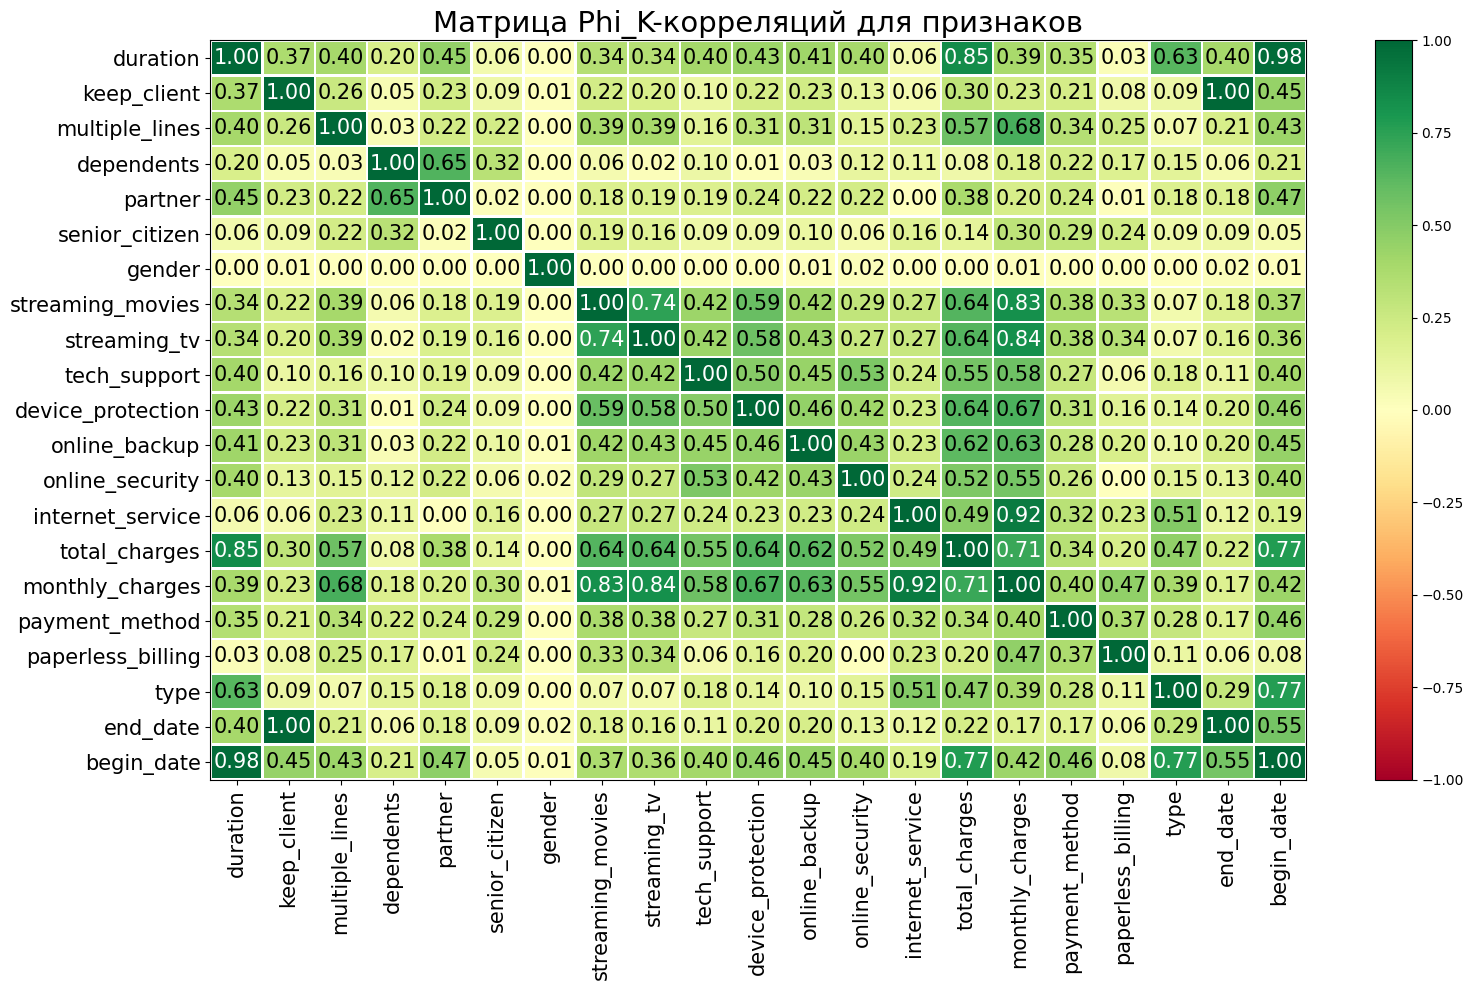

In [53]:
def Pirson_heat():

    # Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
    for i in tqdm(range(1)):

        corr_matrix = data.phik_matrix()
        plot_correlation_matrix(corr_matrix.values, 
                                x_labels=corr_matrix.columns, 
                                y_labels=corr_matrix.index, 
                                title="Матрица Phi_K-корреляций для признаков", 
                                fontsize_factor=1.5, 
                                figsize=(16, 10));
        plt.tight_layout()
        
Pirson_heat()      

## Feature selection (отбор признаков).

**Отмечаем**:
1. Очень высокое значение 0.85 коэффициента Пирсона между признаками 'total_charges' и 'duration'.     
    Физический смысл такой взаимосвязи понятен, так как чем дольше продолжаются контрактные обязательства, тем больше было выплачено по ним.  
    Поэтому один из признаков необходимо удалить. Уберем синтетический признак 'duration'.
2. Очень высокое значение коэффициента Пирсона (более 0.8) между 'monthly_charges' м сразу тремя другими прзнаками: 'streaming_movies', 'streaming_tv' и 'internet_service'.

А потому, удалим синтетический 'duration' и 'monthly_charges':

In [54]:
#data = data.drop(['duration', 'monthly_charges'], axis=1)
#Pirson_heat()

**Отмечаем** что апизнаков с очень сильной взаимной корреляцией (более 0.8 нет)

## 3.7. Исследование сбалансированности целевого признака.

In [55]:
target_distribution = data['keep_client'].value_counts()
display(target_distribution)
print('Отношение между количеством оставшихся и ушедших клиентов:',
      round(target_distribution[1]/target_distribution[0], 1))

1    5942
0    1101
Name: keep_client, dtype: int64

Отношение между количеством оставшихся и ушедших клиентов: 5.4


Отмечаем дисбаланс данных в 'target'.

Тем не менее, так как, согласно задания на проект, мы должны проводить подбор гиперпараметров на кросс-валидации с GridSearchCV, мы не можем изменять количество объектов.

Кроме того, согласно задания мы должны использовать в качестве основной метрику ROC-AUC, которая не чувствительна к дисбалансу классов.

Поэтому оставляем всё, как есть.

## 3.8. Преобразование категориальных признаков.

In [56]:
data.head(2)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,keep_client,duration
0,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,1,31.00
1,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,1,1036.00


Видим:
1. Бинарные признаки со значениями 'Yes' или 'No':   
    `'paperless_billing'`, `'online_security'`, `'online_backup'`,  
    `'device_protection'`, `'tech_support'`,`'streaming_tv'`,  
    `'streaming_movies'`, `'partner'`, `'dependents'`, `'multiple_lines'`.	  
2. Бинарный признак `'senior_citizen'` со значениями *'0'* или *'1'*. Кодировка не нужна. 
3. Бинарный признак `'gender'` со значениями *'Male'* или *'Female'*. 
4. Трёхкатегориальный признак: `'type'` - тип оплаты: 'Month-to-month',  'One year', 'Two year'.
5. Трёхкатегориальный признак: `'internet_service'` - тип подключения к интернет со значениями:
    * *'DSL'* - телефонная линия (DSL, от англ. digital subscriber line, «цифровая абонентская линия»),
    * *'Fiber optic'* - оптоволоконный кабель. 
    * *'No'* - нет подключения.
6. Четырехкатегориальный признак: `'payment_method'` - тип оплаты со значениями: 
    * *'Electronic check'*, 
    * *'Mailed check'*, 
    * *'Bank transfer (automatic)'*, 
    * *'Credit card (automatic)'*.

In [57]:
# Закодируем бинарные категориальные переменные закодируем вручную, 
# присвоив значения 0 или 1 и 0.

columns_binary =['paperless_billing', 'online_security',
                 'online_backup', 'device_protection', 'tech_support',
                 'streaming_tv', 'streaming_movies',
                 'partner', 'dependents', 'multiple_lines']

for priznak in columns_binary:
    data[priznak] = pd.Series(
        np.where(data[priznak].values == 'Yes', 1, 0),data.index)
    
data.head(2)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,keep_client,duration
0,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,31.04,DSL,0,1,0,0,0,0,Female,0,1,0,0,1,31.00
1,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,2071.84,DSL,1,0,1,0,0,0,Male,0,0,0,0,1,1036.00


Преобразуем категориальные признаки в численные с помощью техники прямого кодирования (One-Hot Encoding, OHE), применив функцию pd.get_dummies():

In [58]:
#columns_cat =['gender','type','internet_service','payment_method']
columns_cat =['gender']
data = pd.get_dummies(data, columns=columns_cat, drop_first=True)

А также с помощью OrdinalEncoder:

In [59]:
encoder = OrdinalEncoder()

cat_col = ['type','internet_service','payment_method']

# Получаем список категориальных признаков, вызывая метод fit()
# и преобразуем данные функцией transform():
data[cat_col] = encoder.fit_transform(data[cat_col])

In [60]:
data.head(2)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,multiple_lines,keep_client,duration,gender_Male
0,2020-01-01,2020-02-01,0.00,1,2.00,29.85,31.04,0.00,0,1,0,0,0,0,0,1,0,0,1,31.00,0
1,2017-04-01,2020-02-01,1.00,0,3.00,56.95,2071.84,0.00,1,0,1,0,0,0,0,0,0,0,1,1036.00,1


## 4. Исследование моделей.

#### 4.1. Создание вспомогательных функций.

In [61]:
# колонки для датафрейма с результатами работы моделей
df_results = pd.DataFrame(columns=[
    'model', 'best_score_(ROC-AUC)', 'Accuracy', 
    'fitting_time,с', 'fit_time', 'parameters'])


# Сорварь с набором отработанных моделей. 11111
dictionary_models = {}

#list_dictionary_models = []
#list_dictionary_models.append((2,3))


# Функция для перевода секунд в часы, минуты...
def exec_time(diff_time):
    '''
    Перевод секунд в часы, минуты ...
    '''
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return ("{0:02d}:{1:02d}:{2:02d}".format(h, m, s))


def model_fit_time_metrics(df, model, model_name, X, y):
    '''
    Функция обучения модели, измерения времени обучения,
    расчёта метрик, сохранения результатов в датасет и 
    создания словаря из обученных моделей.
    '''   
    start = time.time()
    
    model.fit(X, y)
    predict = model.predict(X)
    
    fit_time = time.time() - start
    
    if model_name not in list(df['model']):  
        df.loc[len(df.index )] = [model_name, model.best_score_, 
            accuracy_score(y, predict) , 
            round(fit_time, 2), exec_time(fit_time), 
            model.best_params_]
        dictionary_models[model_name] = model
        
        display(df)

### 4.2. Удаление неинформативных признаков.

In [62]:
data.drop(['begin_date', 'end_date'], axis= 1 , inplace= True )

### 4.3. Разделение на выборки train и test.

In [63]:
# Разделение на выборки train и test выделим в отдельную функцию.

def my_train_test():
    '''
    Функция разделения на выборки train и test
    '''

    # Выделим целевой признак:
    features = data.drop('keep_client', axis=1)
    target = data['keep_client']

    # Разделим данные на обучающую и тестовую выборки:
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=TEST_SIZE_FIX, random_state=RANDOM_STATE_FIX,
        stratify=target)

    print('Проверим данные после разбиения на выборки, нет ли потерь:\n')

    if( data.shape[0] == (features_train.shape[0] + features_test.shape[0])):
        print('После разделения датафрейма в обучающей выборке потерь нет.')
    else:
        print('ВНИМАНИЕ! Есть потеря данных в обучающей выборке.\n' \
              'Сумма количества объектов в обучающей выборке НЕ равно ' \
              'количеству объектов исходного датафрейма.')
        print(data.shape[0], features_train.shape[0] + features_test.shape[0])

    if( data.shape[0] == (target_train.shape[0] + target_test.shape[0])):
        print('После разделения датасета в тестовой выборке потерь нет.')
    else:
        print('ВНИМАНИЕ! Есть потеря данных в тестовой выборке.\n' \
              'Сумма количества объектов в тестовой выборке НЕ равно ' \
              'количеству объектов исходного датасета.')
        print(data.shape[0], target_train.shape[0] + target_test.shape[0])
        
    return features_train, features_test, target_train, target_test    
        
        
features_train, features_test, target_train, target_test = my_train_test()       

Проверим данные после разбиения на выборки, нет ли потерь:

После разделения датафрейма в обучающей выборке потерь нет.
После разделения датасета в тестовой выборке потерь нет.


### 4.4. Масштабирование численных признаков обучающей выборки для модели линейной регрессии.

Преобразуем данные с помощью структуры для стандартизации данных — 'StandardScaler'.

In [64]:
# Соберем список признаков для масштабирования:
numeric = ['total_charges', 'monthly_charges', 'duration']
#numeric = ['total_charges']

# Проверим размеры:
print('ДО преобразований:', features_train.shape)

# Создадим объект структуры StandardScaler:
scaler = StandardScaler()

# Настроим объект на обучающих данных:
scaler.fit(features_train[numeric]) 

# Преобразуем обучающую выборку функцией transform():
features_train[numeric] = scaler.transform(features_train[numeric])  

# Преобразуем тестовую выборку этим же scale функцией transform():
features_test[numeric] = scaler.transform(features_test[numeric]) 

# Проверим размеры:
print('ПОСЛЕ преобразований:', features_train.shape)

features_train.head(2)

ДО преобразований: (5282, 18)
ПОСЛЕ преобразований: (5282, 18)


,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,multiple_lines,duration,gender_Male
3387,0.00,0,3.00,-1.47,-0.93,2.00,0,0,0,0,0,0,0,0,0,0,-1.00,0
3367,2.00,1,3.00,0.81,1.19,0.00,1,1,1,1,1,1,0,0,0,1,1.00,1


### 4.5. Линейные модели.

Для оценки качества моделей применяем метрику `ROC-AUC` и `Accuracy`.

#### 4.5.1. `Логистическая регрессия` c GridSearchCV.

In [65]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {
        'penalty': ['none', 'elasticnet', 'l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100]
    }
    
    model = LogisticRegression(solver='liblinear', class_weight='balanced')   
    grid_model = GridSearchCV(model, param_grid = parameters, cv=5, 
                              scoring= 'roc_auc', verbose=0)
   
    model_fit_time_metrics(df_results, grid_model, 
        model.__class__.__name__, features_train, target_train)

  0%|          | 0/1 [00:00<?, ?it/s]

,model,best_score_(ROC-AUC),Accuracy,"fitting_time,с",fit_time,parameters
0,LogisticRegression,0.77,0.71,1.03,00:00:01,"{'C': 1, 'penalty': 'l1'}"


Избавляться от масштабирования после работы с меделью линейной регрессии не будем.  
Масштабирование важно для линейной модели. Остальные работают и без масштабирования.  
Но наличие или отсутствие масштабирования не сказывается на их результатах.

In [66]:
# Заново создадим train и test, без масштабирования.
#features_train, features_test, target_train, target_test = my_train_test() 

#### 4.5.2. Модель `дерево решений` 'Decision Tree' с подбором глубины дерева.

In [67]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth':range(1, 10)}
    
    model = DecisionTreeClassifier(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, 
        scoring='roc_auc', verbose=0)
    
    model_fit_time_metrics(df_results, grid_model, 
        model.__class__.__name__, features_train, target_train)

  0%|          | 0/1 [00:00<?, ?it/s]

,model,best_score_(ROC-AUC),Accuracy,"fitting_time,с",fit_time,parameters
0,LogisticRegression,0.77,0.71,1.03,00:00:01,"{'C': 1, 'penalty': 'l1'}"
1,DecisionTreeClassifier,0.79,0.86,0.55,00:00:01,{'max_depth': 5}


**Промежуточные выводы:**
    
Построены две линейные модели:
* `Логистическая регрессия` с механизмом кросс-валидацией.
* Модель `дерево решений` 'Decision Tree' с подбором глубины дерева.

### 4.6. Ансамблевые методы классификации.

#### 4.6.1. Модель `Cлучайного леса` c подбором гиперпараметров GridSearchCV.

In [68]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth': range(9, 10), 
                  'n_estimators': range(830, 831)}
    
    model = RandomForestClassifier(class_weight = 'balanced', n_jobs=-1,
                                   random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, 
                              scoring='roc_auc', verbose=0)
    
    model_fit_time_metrics(df_results, grid_model, 
        model.__class__.__name__, features_train, target_train)   

  0%|          | 0/1 [00:00<?, ?it/s]

,model,best_score_(ROC-AUC),Accuracy,"fitting_time,с",fit_time,parameters
0,LogisticRegression,0.77,0.71,1.03,00:00:01,"{'C': 1, 'penalty': 'l1'}"
1,DecisionTreeClassifier,0.79,0.86,0.55,00:00:01,{'max_depth': 5}
2,RandomForestClassifier,0.83,0.88,8.30,00:00:08,"{'max_depth': 9, 'n_estimators': 830}"


#### 4.6.2. Модель `GradientBoostingClassifier` c подбором гиперпараметров GridSearchCV.

In [69]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(1, 6),
                  'n_estimators': range(23, 28, 1), 
                  'learning_rate': [0.3] }
    
    model = GradientBoostingClassifier(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, 
                              scoring='roc_auc', verbose=0)
    
    model_fit_time_metrics(df_results, grid_model, 
        model.__class__.__name__, features_train, target_train)

  0%|          | 0/1 [00:00<?, ?it/s]

,model,best_score_(ROC-AUC),Accuracy,"fitting_time,с",fit_time,parameters
0,LogisticRegression,0.77,0.71,1.03,00:00:01,"{'C': 1, 'penalty': 'l1'}"
1,DecisionTreeClassifier,0.79,0.86,0.55,00:00:01,{'max_depth': 5}
2,RandomForestClassifier,0.83,0.88,8.30,00:00:08,"{'max_depth': 9, 'n_estimators': 830}"
3,GradientBoostingClassifier,0.86,0.94,16.85,00:00:17,"{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 27}"


**Промежуточные выводы:**

Построены две ансамблевые модели:
* Модель `Cлучайного леса` c подбором гиперпараметров GridSearchCV.
* Модель `GradientBoostingClassifier`  c подбором гиперпараметров GridSearchCV.

### 4.7. Итеративные модели.

#### 4.7.1. Модель градиентного бустинга `LightGBM` c подбором гиперпараметров GridSearchCV.

In [70]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' :  range(1, 5),
                  'n_estimators': range(1162, 1168, 12), 
                  'learning_rate': [0.03]}
    
    model = LGBMClassifier(random_state=RANDOM_STATE_FIX, objective='binary')
    grid_model = GridSearchCV(model, parameters, cv=5, n_jobs=-1,
                              scoring='roc_auc', verbose=0)
    
    model_fit_time_metrics(df_results, grid_model, 
        model.__class__.__name__, features_train, target_train)    

  0%|          | 0/1 [00:00<?, ?it/s]

,model,best_score_(ROC-AUC),Accuracy,"fitting_time,с",fit_time,parameters
0,LogisticRegression,0.77,0.71,1.03,00:00:01,"{'C': 1, 'penalty': 'l1'}"
1,DecisionTreeClassifier,0.79,0.86,0.55,00:00:01,{'max_depth': 5}
2,RandomForestClassifier,0.83,0.88,8.30,00:00:08,"{'max_depth': 9, 'n_estimators': 830}"
3,GradientBoostingClassifier,0.86,0.94,16.85,00:00:17,"{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 27}"
4,LGBMClassifier,0.90,0.96,3.16,00:00:03,"{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 1162}"


#### 4.7.2. Модель градиентного бустинга `CatBoost` c подбором гиперпараметров GridSearchCV.

In [71]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(2, 7, 1),
                  'iterations': range(367, 375, 2),
                  'learning_rate': [0.4],
                  'verbose': [0]}
    
    model = CatBoostClassifier(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, n_jobs=-1,
                              scoring='roc_auc')
    
    model_fit_time_metrics(df_results, grid_model, 
       model.__class__.__name__, features_train, target_train)  

  0%|          | 0/1 [00:00<?, ?it/s]

,model,best_score_(ROC-AUC),Accuracy,"fitting_time,с",fit_time,parameters
0,LogisticRegression,0.77,0.71,1.03,00:00:01,"{'C': 1, 'penalty': 'l1'}"
1,DecisionTreeClassifier,0.79,0.86,0.55,00:00:01,{'max_depth': 5}
2,RandomForestClassifier,0.83,0.88,8.30,00:00:08,"{'max_depth': 9, 'n_estimators': 830}"
3,GradientBoostingClassifier,0.86,0.94,16.85,00:00:17,"{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 27}"
4,LGBMClassifier,0.90,0.96,3.16,00:00:03,"{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 1162}"
5,CatBoostClassifier,0.93,0.95,32.25,00:00:32,"{'iterations': 373, 'learning_rate': 0.4, 'max_depth': 2, 'verbose': 0}"


#### 4.7.3. Модель градиентного бустинга `XGBoost` с использованием GridSearch.

In [72]:
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    parameters = {'max_depth' : range(5, 10),
                  'n_estimators': range(260, 271, 2)}
    
    model = xgb.XGBRFClassifier(random_state=RANDOM_STATE_FIX)
    grid_model = GridSearchCV(model, parameters, cv=5, n_jobs=-1,
                              scoring='roc_auc')
    
    model_fit_time_metrics(df_results, grid_model, 
       model.__class__.__name__, features_train, target_train)

  0%|          | 0/1 [00:00<?, ?it/s]

,model,best_score_(ROC-AUC),Accuracy,"fitting_time,с",fit_time,parameters
0,LogisticRegression,0.77,0.71,1.03,00:00:01,"{'C': 1, 'penalty': 'l1'}"
1,DecisionTreeClassifier,0.79,0.86,0.55,00:00:01,{'max_depth': 5}
2,RandomForestClassifier,0.83,0.88,8.30,00:00:08,"{'max_depth': 9, 'n_estimators': 830}"
3,GradientBoostingClassifier,0.86,0.94,16.85,00:00:17,"{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 27}"
4,LGBMClassifier,0.90,0.96,3.16,00:00:03,"{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 1162}"
5,CatBoostClassifier,0.93,0.95,32.25,00:00:32,"{'iterations': 373, 'learning_rate': 0.4, 'max_depth': 2, 'verbose': 0}"
6,XGBRFClassifier,0.83,0.88,46.67,00:00:47,"{'max_depth': 7, 'n_estimators': 270}"


**Промежуточные выводы:**

Построены три итеративные модели:
* Модель градиентного бустинга `LightGBM` c подбором гиперпараметров GridSearchCV.
* Модель градиентного бустинга `CatBoost` c подбором гиперпараметров GridSearchCV.
* Модель градиентного бустинга `XGBoost` с использованием GridSearch.

### 4.8. Создание и обучение моделей на Pipeline.

In [73]:
%%time

start_time = time.time()

C_range = loguniform(1e-3, 1).rvs(10000, random_state=RANDOM_STATE_FIX).round(3)
estimators_range = uniform(1,500).rvs(10000, random_state=RANDOM_STATE_FIX).astype(int)
max_depth_range = uniform(1,30).rvs(10000, random_state=RANDOM_STATE_FIX).astype(int)

pipeline = make_imblearn_pipeline(RandomForestClassifier())
pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])

param_grid = [
    {   'LogisticRegression': [LogisticRegression()],
        'clf__C': C_range,
        'clf_pipeline__standardscaler': 
             [MinMaxScaler(), StandardScaler()],
    },
    
    {
        'clf': [DecisionTreeClassifier(random_state=RANDOM_STATE_FIX)],
        'clf__max_depth': max_depth_range
    },

    {
        'clf': [RandomForestClassifier(random_state=RANDOM_STATE_FIX)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [GradientBoostingClassifier(random_state=RANDOM_STATE_FIX, 
                                           learning_rate=0.3)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [LGBMClassifier(random_state=RANDOM_STATE_FIX, 
                               learning_rate=0.3)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
      
    {
        'clf': [CatBoostClassifier(random_state=RANDOM_STATE_FIX, verbose=0)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    },
    
    {
        'clf': [xgb.XGBRFClassifier(random_state=RANDOM_STATE_FIX, eta=1)],
        'clf__n_estimators': estimators_range,
        'clf__max_depth': max_depth_range,
    }
]

Pipe_model = RandomizedSearchCV(pipeline,  
                                param_grid, 
                                n_iter=30,
                                cv=5, 
                                scoring = 'roc_auc',
                                random_state=RANDOM_STATE_FIX,
                               )

# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)):
    Pipe_model.fit(features_train, target_train)
    
print('best_params :', Pipe_model.best_params_)
print('-' * 50)
print('best_score_(ROC-AUC) :', round(abs(Pipe_model.best_score_), 3)) 

time_pipe_working = time.time() - start_time    
print('Execiting time:', exec_time(time_pipe_working))

  0%|          | 0/1 [00:00<?, ?it/s]

best_params : {'clf__n_estimators': 152, 'clf__max_depth': 3, 'clf': GradientBoostingClassifier(learning_rate=0.3, n_estimators=152,
                           random_state=12345)}
--------------------------------------------------
best_score_(ROC-AUC) : 0.902
Execiting time: 00:24:50
CPU times: total: 1h 29min 21s
Wall time: 24min 50s


**Посмотрим тройку лучших моделей, рассчитанных Pipeline.**

In [74]:
cv_results = pd.DataFrame(Pipe_model.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results = cv_results.reset_index(drop=True)
cv_results[['rank_test_score', 'params', 'mean_test_score', 
            'mean_fit_time']].head(3)

,rank_test_score,params,mean_test_score,mean_fit_time
0,1,"{'clf__n_estimators': 152, 'clf__max_depth': 3, 'clf': GradientBoostingClassifier(learning_rate=0.3, n_estimators=152, random_state=12345)}",0.90,0.72
1,2,"{'clf__n_estimators': 312, 'clf__max_depth': 3, 'clf': LGBMClassifier(learning_rate=0.3, random_state=12345)}",0.90,0.11
2,3,"{'clf__n_estimators': 480, 'clf__max_depth': 8, 'clf': LGBMClassifier(learning_rate=0.3, random_state=12345)}",0.88,0.44


**Промежуточные выводы:**

Построен конвейер pipeline для построения 7 моделей:

* `LogisticRegression` - линейная модель.
* `DecisionTreeClassifier` - линейная модель.
* `RandomForestClassifier` - ансамблевая модель.
* `GradientBoostingClassifier` - ансамблевая модель.
* `LGBMClassifier` - итеративная модель градиентного бустинга.
* `CatBoostClassifier` - итеративная модель градиентного бустинга.
* `XGBRFClassifier` - итеративная модель градиентного бустинга.

In [75]:
# Сформируем имя лучшей pipeline модели:

text = str(cv_results.params[0]['clf'])
try:
    found = re.search('(.+?)Classifier', text).group(1) + \
            'C+Pipeline'
except AttributeError:
    found = ''
    
# Сформируем список параметров лучшей pipeline модели:
param_pipe = '{' + \
             'clf__n_estimators : ' + \
             str(cv_results.params[0]['clf__n_estimators']) + \
             ', clf__max_depth : ' + \
             str(cv_results.params[0]['clf__max_depth']) + \
            '}'

# Добавим модель, рассчитанную pipeline в наш список моделей:
if found not in list(df_results['model']):  

    df_results.loc[len(df_results.index )] = \
        [found, 
         abs(cv_results.mean_test_score[0]),
         accuracy_score(Pipe_model.predict(features_train), target_train),
         cv_results.mean_fit_time[0],
    #     time_pipe_working,
         exec_time(cv_results.mean_fit_time[0]),
    #     exec_time(time_pipe_working),
         'Full time: ' + str(exec_time(time_pipe_working)) + 
         '  ' + param_pipe 
        ]

    dictionary_models[found] = Pipe_model

pd.set_option('display.float_format', '{:.2f}'.format) 

### 4.9. Выбор лучшей модели (по метрике на кроссвалидации model.best_score_).

In [76]:
# Отсортируем модели по значению MAE:
df_final = df_results.sort_values(by = ['best_score_(ROC-AUC)'], ascending = False)
df_final = df_final.reset_index(drop=True)
df_final

,model,best_score_(ROC-AUC),Accuracy,"fitting_time,с",fit_time,parameters
0,CatBoostClassifier,0.93,0.95,32.25,00:00:32,"{'iterations': 373, 'learning_rate': 0.4, 'max_depth': 2, 'verbose': 0}"
1,GradientBoostingC+Pipeline,0.90,0.96,0.72,00:00:01,"Full time: 00:24:50 {clf__n_estimators : 152, clf__max_depth : 3}"
2,LGBMClassifier,0.90,0.96,3.16,00:00:03,"{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 1162}"
3,GradientBoostingClassifier,0.86,0.94,16.85,00:00:17,"{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 27}"
4,XGBRFClassifier,0.83,0.88,46.67,00:00:47,"{'max_depth': 7, 'n_estimators': 270}"
5,RandomForestClassifier,0.83,0.88,8.30,00:00:08,"{'max_depth': 9, 'n_estimators': 830}"
6,DecisionTreeClassifier,0.79,0.86,0.55,00:00:01,{'max_depth': 5}
7,LogisticRegression,0.77,0.71,1.03,00:00:01,"{'C': 1, 'penalty': 'l1'}"


Наибольшее значение best_score_(ROC-AUC), равное 0.93  имеет модель : CatBoostClassifier


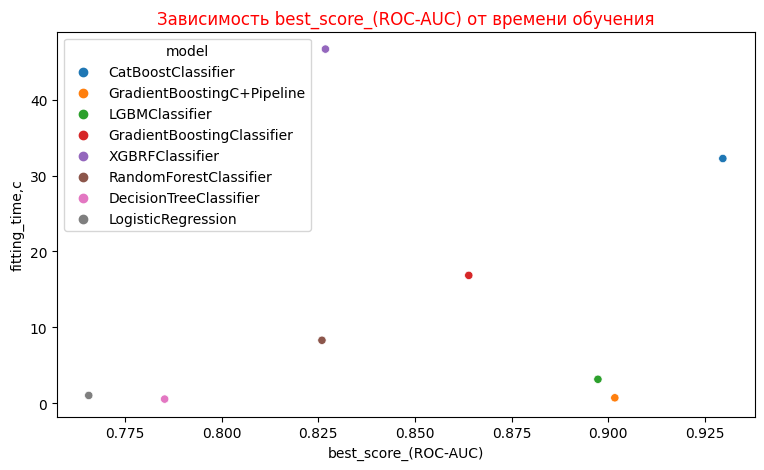

In [77]:
print('Наибольшее значение best_score_(ROC-AUC), равное', 
      round(df_final['best_score_(ROC-AUC)'][0], 3), \
      ' имеет модель :', df_final.model[0])

# Представим все отработанные модели на графике.

plt.figure(figsize = (9,5))
sns.scatterplot(data = df_final, x ='best_score_(ROC-AUC)', y='fitting_time,с', hue="model")
plt.title('Зависимость best_score_(ROC-AUC) от времени обучения',
          fontsize=12, color='red');
plt.show()

**Промежуточные выводы:**

In [78]:
print('Лучшей моделью является', df_final.model[0], 
      'имеющая следующие значения метрик:'
      '\n- best_score_(ROC-AUC):',
      round(df_final['best_score_(ROC-AUC)'][0], 2),               
      '\n- время обучения:', df_final.fit_time[0])

Лучшей моделью является CatBoostClassifier имеющая следующие значения метрик:
- best_score_(ROC-AUC): 0.93 
- время обучения: 00:00:32


**Построение кривых ROC**

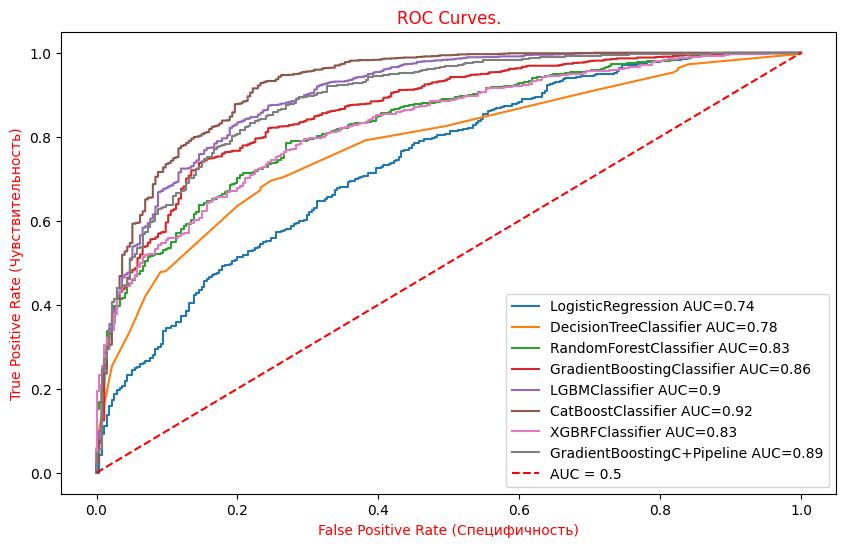

In [79]:
plt.figure(figsize = (10,6))

for key, value in dictionary_models.items():
    y_pred = value.predict_proba(features_test)[:, 1]
    fpr, tpr, _ = roc_curve(target_test, y_pred)
    auc = round(roc_auc_score(target_test, y_pred), 2)
    plt.plot(fpr, tpr, label = key + " AUC="+str(auc))

plt.plot([0, 1], [0, 1],'r--', label="AUC = 0.5")   

plt.xlabel('False Positive Rate (Специфичность)', 
           fontsize=10, color='red')
plt.ylabel('True Positive Rate (Чувствительность)', 
           fontsize=10, color='red')
plt.title('ROC Curves.', fontsize=12, color='red')

plt.legend(); 

* **Чувствительность**: вероятность того, что модель предсказывает положительный результат для наблюдения, когда результат действительно положительный.
* **Специфичность**: вероятность того, что модель предсказывает отрицательный результат для наблюдения, когда результат действительно отрицательный.

**Отмечаем**: модель `'CatBoostClassifier'` имеет наибольшую площадь под кривой и является лучшей.

### 4.10. Стекинг.

In [80]:
%%time
# Чтобы видеть, что процесс выполняется, поставим tqdm с разовым циклом:
for _ in tqdm(range(1)): 
    
    model_names = [key for key in dictionary_models.keys()]    
    models = [value for value in dictionary_models.values()]  

    stacked_model = StackingClassifier(list(zip(model_names, models)),
                    final_estimator = LogisticRegression(),
                    n_jobs = -1, verbose = 0) 

    stacked_model.fit(features_train, target_train)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 594 ms
Wall time: 1h 48min 38s


### 4.11. Определение итоговой метрики на тестовой выборке.

In [81]:
predict_best_model = dictionary_models[df_final.model[0]].predict(features_test) 

ROC_AUC_best_model_test = roc_auc_score(target_test, predict_best_model)
accuracy_best_model_test = accuracy_score(predict_best_model, target_test)
print('Значения метрик, рассчитанные для лучшей модели',
      df_final.model[0], 'на тестовой выборке:')
print('ROC_AUC =', round(ROC_AUC_best_model_test, 2))
print('Accuracy =', round(accuracy_best_model_test, 2))


predict_stacked = stacked_model.predict(features_test) 

ROC_AUC_stacked_model = roc_auc_score(target_test, predict_stacked)
accuracy_stacked_model = accuracy_score(predict_stacked, target_test)
print("\nЗначения метрик, рассчитанные для 'стекинг метода' на тестовой выборке:")
print('ROC_AUC =', round(ROC_AUC_stacked_model, 2))
print('Accuracy =', round(accuracy_stacked_model, 2))

Значения метрик, рассчитанные для лучшей модели CatBoostClassifier на тестовой выборке:
ROC_AUC = 0.78
Accuracy = 0.92

Значения метрик, рассчитанные для 'стекинг метода' на тестовой выборке:
ROC_AUC = 0.8
Accuracy = 0.93


### 4.12. Анализ важности признаков выбранной модели.

Так как модель `Pipeline` не имеет 'feature_importances_' то, если она и окажется лучшей (с номером 0 по порядку), строим график feature_importances_ для следующей (т.е. с номером 1 по списку) модели.

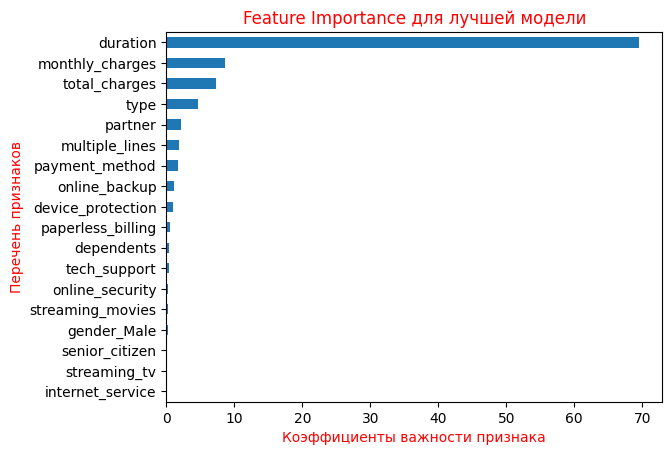

In [82]:
if 'Pipeline' in df_final.model[0]:
    num = 1
else:
    num = 0
    
# Построим таблицу важности обучающих признаков:
pd.Series(index=features_train.columns, 
          data=dictionary_models[df_final.model[num]]. \
              best_estimator_.feature_importances_) \
    .sort_values().plot(kind='barh')
_ = plt.title("Feature Importance для лучшей модели",
              fontsize=12, color='red')
plt.xlabel("Коэффициенты важности признака", fontsize=10, color='red')
plt.ylabel("Перечень признаков", fontsize=10, color='red');

**Отмечаем**:
* Наиболее важными являются признаки:
    * *'duration'* - продолжительность времени, в течение которого человек был клиентов телекоммуникационной компании;
    * *'mouthly_charges'* - размер ежемесячной оплаты;
    * *'total_charges'* - размер полной выплаты клиентов компании за все время взаимного сотрудничества.
* Наименее важными являются:
    * признаки с перечнем услуг.

### 4.13. Проверка на константной модели.

In [83]:
model_dc = DummyClassifier(strategy='most_frequent', 
                           random_state=RANDOM_STATE_FIX)
model_dc.fit(features_train, target_train)
predict_dum = model_dc.predict(features_test) 

ROC_AUC_DC_model = roc_auc_score(target_test, predict_dum)

print('Проведена проверка модели на адекватность.\n')
print('Для константной модели ROC_AUC =', 
      round(ROC_AUC_DC_model, 2), end='')
if (ROC_AUC_DC_model < ROC_AUC_best_model_test):
    print(', что меньше, чем для лучшей модели на тестовой выборке: ', 
          round(ROC_AUC_best_model_test, 2), '.', sep='')
    print('Модель - адекватная.')
else:
    print(', что больше, чем для лучшей модели на тестовой выборке: ',
         round(ROC_AUC_best_model_test, 2), '.', sep='')
    print('Модель НЕ прошла проверку на адекватность!') 

Проведена проверка модели на адекватность.

Для константной модели ROC_AUC = 0.5, что меньше, чем для лучшей модели на тестовой выборке: 0.78.
Модель - адекватная.


# 5. Итоговые выводы.

###### **По результатам исследования можно отметить следующие факты и сделать приводимые ниже выводы:**

1. Для проведения исследования получены данные по клиентам телекоммуникационной компании и услугам, оказанным им в в период с 2013-10-01 по 2020-02-01:
    * `'contract_new.csv'` — информация о договоре;
    * `'personal_new.csv'` — персональные данные клиента;
    * `'internet_new.csv'` — информация об интернет-услугах;
    * `'phone_new.csv'` — информация об услугах телефонии.
2. Провёл EDA анализ:
    * объединение датасетов;
    * преобразование значений даты и времени из object в datetime;
    * заполнение пропущенных значений;
    * создание синтетических признаков: целевого признака и длительность договорных отношений;
    * удаление неинформативгых признаков;
    * проверка мультиколлинеарности признаков;
    * исследование сбалансированности целевого признака;
    * преобразование категориальных признаков;  
3. Изучил закономерности поведения клиентов:
    * Распределение количества заключенных/расторгнутых контрактов по времени.
        * После скачкообразного количества заключенных контрактов на рубеже 2014 года (видимо, после создания телекоммуникационной компании) очень быстро их количество уменьшилось.
        * Количество заключаемых новых контрактов постоянно уменьшается, практически до нуля к конце 2020 года.
        * Примерно через полгода после образования компании, люди стали уходить от сотрудничества с ней. И этот процесс только увеличивался.
     * Распределение числа клиентов по типу оплаты.   
        * распределение числа клиентов по способу оплаты не содержит аномальных выбросов. Тем не менее, наболюдаем, что большинство клиентов предпочитают электронную оплату.
4. Построил и обучил 7 моделей в `GridSearchCV`:    
    - **LinearRegression** - линейная модель.
    - **DecisionTreeRegressor** - линейная модель.
    - **RandomForestRegressor** - ансамблевая модель.
    - **GradientBoostingRegressor** - ансамблевая модель.
    - **LGBMRegressor** - итеративная модель градиентного бустинга.
    - **CatBoostRegressor** - итеративная модель градиентного бустинга.
    - **XGBRFRegressor** - итеративная модель градиентного бустинга. 
5. Построил конвейер `pipeline` для создания и оценки 7 моделей в `GridSearchCV`:    
    - **LinearRegression** - линейная модель.
    - **DecisionTreeRegressor** - линейная модель.
    - **RandomForestRegressor** - ансамблевая модель.
    - **GradientBoostingRegressor** - ансамблевая модель.
    - **LGBMRegressor** - итеративная модель градиентного бустинга.
    - **CatBoostRegressor** - итеративная модель градиентного бустинга.
    - **XGBRFRegressor** - итеративная модель градиентного бустинга.  
7. Значения `ROC-AUC`, рассчитанные для `'стекинг метода'` на тестовой выборке: 0.80.  
8. В качестве лучшей определил модель `CatBoostClassifier` со следующими значениями значения метрик:  
    * `best_score_ (ROC-AUC)`: 0.93 
    * `ROC-AUC на тестовой выборке`: 0.78 
    * `время обучения модели`: 00:01:33
8. Провёл анализ важности признаков выбранной модели. Установил:
    * Наиболее важными являются признаки:
        * *'duration'* - продолжительность времени, в течение которого человек был клиентов телекоммуникационной компании;
        * *'mouthly_charges'* - размер ежемесячной оплаты;
        * *'total_charges'* - размер полной выплаты клиентов компании за все время взаимного сотрудничества.
    * Наименее важными являются:
        * признаки с перечнем услуг.
10. Провёл проверку адекватности созданной лучшей модели на константной выборке. Модель - адекватная.
11. Специалистам телекоммуникационной компании можно рекомендовать использовать модель **`CatBoostClassifier`**.

Для работы на GitHub:  
[Вернуться к общему списку проектов курса Data_Science Яндекс-практикума](../README.md)